# Atividade Prática 6

>### Igor Martinelli           9006336

>### Zoltán Hirata Jetsmen     9293272

## Para a presente prática será escolhido o conjunto de dados wine, que é um conjunto de dados de classificação que ja fora utilizado nas práticas anteriores. Além disso, será removido os exemplos da classe 3, de modo a tornar o problema binário.

In [1]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
wine = datasets.load_wine()
wine = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                     columns= wine['feature_names'] + ['target'])

wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


>### Eliminando os exemplos da classe 2 de modo a tornar o problema binário.

In [3]:
 wine = wine[(wine.target == 0) | (wine.target == 1)]

>## 1 - Atributos e medida de avaliação

>>### Os atributos escolhidos para a prática serão color_intensity, malic_acid, alcohol, hue e proline. Tais atributos foram escolhidos pois eles ja foram utilizados em práticas anteriores e se mostraram muito bons para a separação das classes. A medida de avaliação utilizada será a acurácia. Essa medida foi escolhida pois, a acurácia permite se ter uma boa visualização da taxa de acerto que o algoritmo teve.

In [4]:
wine = wine.iloc[:, [0, 1, 9, 10, 12, 13]]

# Função de classificação para k-fold e leave-one-out

In [17]:
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Perceptron

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

def classificacao(data, columns, target, score=accuracy_score, score_name='acurácia', 
                  folds=5, plot=True):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    score:      Função. A função que calcula a medida de desempenho desejada. Deve ser uma 
                função que compara dois vetores, o primeiro vetor são os valores preditos
                pelo classificador, o segundo os rótulos reais
                Vide exemplo das funções em 
                http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
                como por exemplo, sklearn.metrics.accuracy_score
                http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    score_name: String. Uma string com o nome da medida de desempenho
    folds:      Inteiro. Número de folds na validação cruzada
    plot:       Booleano. True para plotar os gráficos False para não plotar
    ---------------------------------------------------------------
    Realiza a classificação em 6 modelos (perceptron, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, 3NN, 5NN, e 7NN)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados e as medidas de desempenho
    """
    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    prcp = Perceptron()
    svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    _3nn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    _5nn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    _7nn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto')
    
    clfs = [prcp, svm_n, dt, _3nn, _5nn, _7nn]
    clfs_names = ['perceptron', 'svm_poly', 'dt', '3nn', '5nn', '7nn']
    
    # prepara validação cruzada
    # faz divisão do dataset em 5 partes
    cv = KFold(n_splits=folds, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results = {'perceptron':[], 'svm_poly':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # valores predito pelo classificador
            y_pred = clf.predict(x_test)
            # rótulos verdadeiros convertidos para array
            y_test = np.array(y_test)
            
            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( score(y_test, y_pred) )
    
    if not plot:
        return {'results': results, 'clfs':clfs}
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - %s'%(score_name)
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}

# Função de classificação para bootstrap

In [16]:
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Perceptron

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')
def classificacao_bootstrap(bootstrap_dts, columns, target, score=accuracy_score, score_name='acurácia', 
                  folds=5, plot=True):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    score:      Função. A função que calcula a medida de desempenho desejada. Deve ser uma 
                função que compara dois vetores, o primeiro vetor são os valores preditos
                pelo classificador, o segundo os rótulos reais
                Vide exemplo das funções em 
                http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
                como por exemplo, sklearn.metrics.accuracy_score
                http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    score_name: String. Uma string com o nome da medida de desempenho
    folds:      Inteiro. Número de folds na validação cruzada
    plot:       Booleano. True para plotar os gráficos False para não plotar
    ---------------------------------------------------------------
    Realiza a classificação em 6 modelos (perceptron, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, 3NN, 5NN, e 7NN)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados e as medidas de desempenho
    """
    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    prcp = Perceptron()
    svm_n = SVC(C=10*len(bootstrap_dts[0]), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(bootstrap_dts[0])*0.1))
    _3nn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    _5nn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    _7nn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto')

    clfs = [prcp, svm_n, dt, _3nn, _5nn, _7nn]
    clfs_names = ['perceptron', 'svm_poly', 'dt', '3nn', '5nn', '7nn']


    # itera para cada classificador fazendo treino e teste
    results = {'perceptron':[], 'svm_poly':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for dt_boot in bootstrap_dts:

            # separa 80% para treino e 20% para teste
            test = dt_boot.sample(n=int(len(dt_boot)*0.2), replace=False)
            train = dt_boot.iloc[-test.index]

            # faz o treino do modelo
            clf = c.fit(X=train.iloc[:, columns], y=train.iloc[:, target])

            # valores predito pelo classificador
            y_pred = clf.predict(test.iloc[:, columns])
            # rótulos verdadeiros convertidos para array
            y_test = np.array(test.iloc[:, target])

            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( score(y_test, y_pred) )

    if not plot:
        return {'results': results, 'clfs':clfs}
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - %s'%(score_name)
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}

## Realizando a classificação com a utilização da acurácia

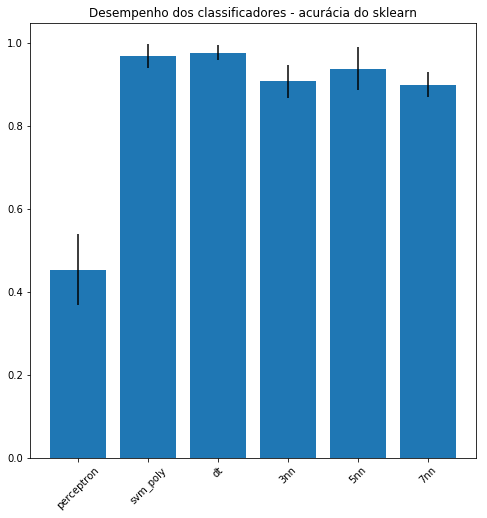

In [18]:
target = len(wine.columns) -1
columns = list(range(5))
clf_acc = classificacao(wine, columns, target, accuracy_score, 'acurácia do sklearn')

>### Pelos resultados apresentados, podemos observar que o modelo svm e a árvore de decisão são os melhores modelos para esse caso, pois apresentaram a acurácia muito perto de 100%. Além disso, o 7-nearest neighbour também teve uma acurácia muito boa, ficando abaixo somente desses dois.

># 3 - Implementação dos procedimentos de amostragem

# Ten fold cross validation

In [7]:
def ten_fold_cross_validation(dataset):
    size = len(dataset)
    step = int(np.floor(len(dataset)/10))

    for i in range(0, size, step):
        test = []
        train = []
        #shuffle do dataset para aleatorizar.
        dataset = dataset.sample(frac=1).reset_index(drop=True)

        test = dataset.iloc[i:i+step, :]
        train = pd.concat([dataset.iloc[0:i, :], dataset.iloc[i+step:, :]], axis=0)
        # aqui é executada a função de classificação passando-se o conjunto de treino e teste.

# Leave one out

In [8]:
def leave_one_out(dataset):
    for i in range(len(dataset)):
        test = []
        train = []

        test = dataset.iloc[i:i+1, :]
        train = pd.concat([dataset.iloc[0:i, :], dataset.iloc[i+1:, :]], axis=0)
        # aqui é executada a função de classificação passando-se o conjunto de treino e teste.

# Bootstrap

In [9]:
def bootstrap(dataset, n_samples):
    # criando amostras de bootstrap
    df_aux = dataset.copy()
    bootstrap_samples = n_samples
    n_samples = df_aux.shape[0]
    bootstrap_dts = [df_aux.sample(n=n_samples, replace=True) for i in range(bootstrap_samples)]
    #aqui é gerada as amostras de bootstrap para realizar a classificação posteriormente.
    return bootstrap_dts

## Sub e superamostragem (optou-se por realizar uma sub e superamostragem para 100 e 1000 amostras considerando que o conjunto reduzido para binário continha 130 amostras, o que impossibilitaria de fazer uma subamostragem para 200, sendo que para esse caso seria considerada uma superamostragem.

In [10]:
df_aux_undersampling = pd.DataFrame()
for classes in wine.target.unique():
    df_wine_undersampling = wine[wine.target == classes].sample(n=50, replace=True)
    df_aux_undersampling = pd.concat([df_aux_undersampling, df_wine_undersampling], )
    
df_aux_undersampling.reset_index(drop=True, inplace=True)
df_aux_undersampling.target.value_counts()

1.0    50
0.0    50
Name: target, dtype: int64

In [11]:
df_aux_oversampling = pd.DataFrame()
for classes in wine.target.unique():
    df_wine_oversampling = wine[wine.target == classes].sample(n=500, replace=True)
    df_aux_oversampling = pd.concat([df_aux_oversampling, df_wine_oversampling], )
    
df_aux_oversampling.reset_index(drop=True, inplace=True)
df_aux_oversampling.target.value_counts()

1.0    500
0.0    500
Name: target, dtype: int64

## Execução da classificação para os conjuntos de under e oversampling respectivamente, para o ten fold cross validation

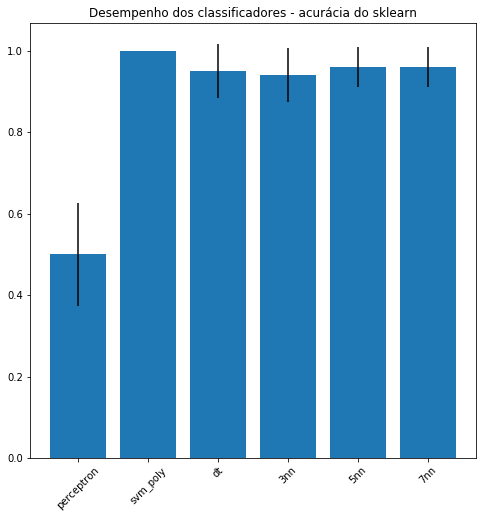

In [22]:
clf_acc = classificacao(df_aux_undersampling, columns, target, accuracy_score, 'acurácia do sklearn', folds=10)

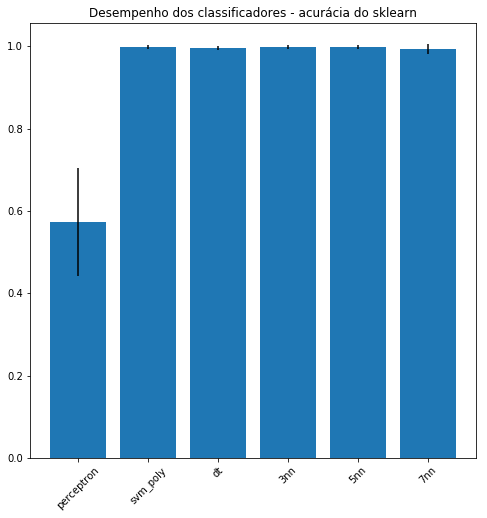

In [23]:
clf_acc = classificacao(df_aux_oversampling, columns, target, accuracy_score, 'acurácia do sklearn', folds=10)

## Execução da classificação para os conjuntos de under e oversampling respectivamente, para o leave_one_out

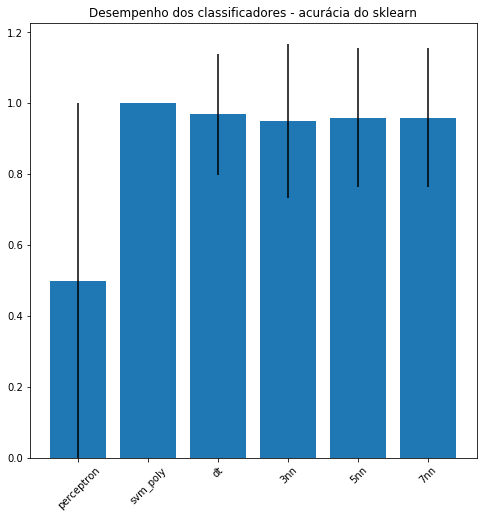

In [25]:
clf_acc = classificacao(df_aux_undersampling, columns, target, accuracy_score, 'acurácia do sklearn', folds=100)

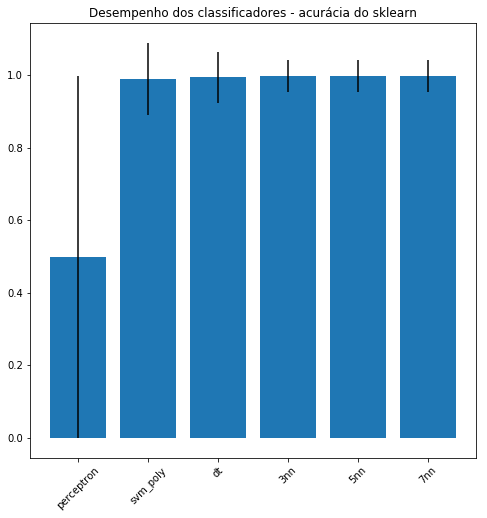

In [26]:
clf_acc = classificacao(df_aux_oversampling, columns, target, accuracy_score, 'acurácia do sklearn', folds=1000)

## Execução da função de classificação para os conjuntos de under e oversampling respectivamente, utilizando bootstrap

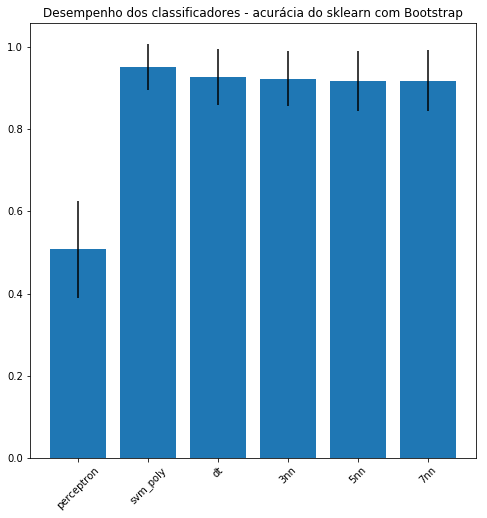

In [57]:
bootstrap_samples = bootstrap(df_aux_undersampling, 1000)
clf_boot_acc = classificacao_bootstrap(bootstrap_samples, columns, target, accuracy_score, 'acurácia do sklearn com Bootstrap')

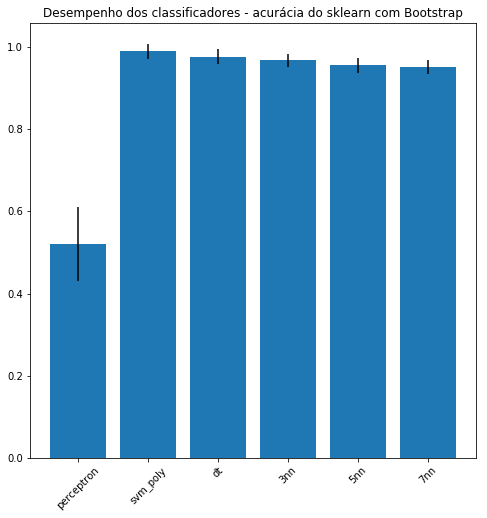

In [58]:
bootstrap_samples = bootstrap(df_aux_oversampling, 1000)
clf_boot_acc = classificacao_bootstrap(bootstrap_samples, columns, target, accuracy_score, 'acurácia do sklearn com Bootstrap')

># 4 - Matriz de confusão

>>### O procedimento escolhido para esta etapa será o ten fold cross validation. Para a execução desta, iremos alterar a função de classificação para que ela retorne os valores preditos e os esperados, de modo que possamos utilizar a matriz de confusão para estes.

In [22]:
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Perceptron

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

def classificacao_conf_matrix(data, columns, target, score=accuracy_score, score_name='acurácia', 
                  folds=5, plot=True):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    score:      Função. A função que calcula a medida de desempenho desejada. Deve ser uma 
                função que compara dois vetores, o primeiro vetor são os valores preditos
                pelo classificador, o segundo os rótulos reais
                Vide exemplo das funções em 
                http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
                como por exemplo, sklearn.metrics.accuracy_score
                http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    score_name: String. Uma string com o nome da medida de desempenho
    folds:      Inteiro. Número de folds na validação cruzada
    plot:       Booleano. True para plotar os gráficos False para não plotar
    ---------------------------------------------------------------
    Realiza a classificação em 6 modelos (perceptron, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, 3NN, 5NN, e 7NN)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados e as medidas de desempenho
    """
    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    prcp = Perceptron()
    svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    _3nn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    _5nn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    _7nn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto')
    
    clfs = [prcp, svm_n, dt, _3nn, _5nn, _7nn]
    clfs_names = ['perceptron', 'svm_poly', 'dt', '3nn', '5nn', '7nn']
    
    # prepara validação cruzada
    # faz divisão do dataset em 5 partes
    cv = KFold(n_splits=folds, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results = {'perceptron':[], 'svm_poly':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[], 'y_pred':[[]], 'y_test':[[]]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            ypred = []
            ytest = []
            
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # valores predito pelo classificador
            y_pred = clf.predict(x_test)
            # rótulos verdadeiros convertidos para array
            y_test = np.array(y_test)
            
            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( score(y_test, y_pred) )
           
            ypred.append(y_pred)
            ytest.append(y_test)
        results['y_pred'].append(ypred)
        results['y_test'].append(ytest)
        
    if not plot:
        return {'results': results, 'clfs':clfs}
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - %s'%(score_name)
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}

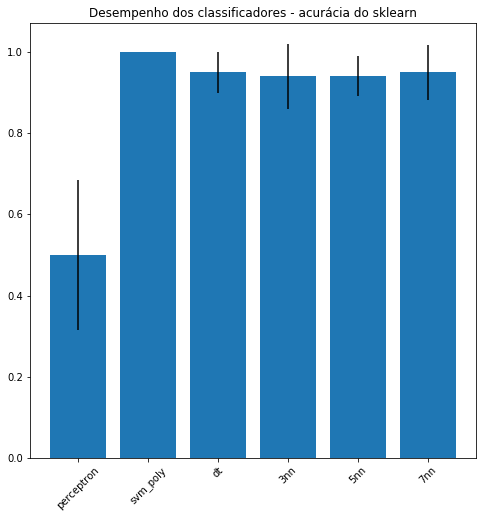

In [23]:
clf_acc = classificacao_conf_matrix(df_aux_undersampling, columns, target, accuracy_score, 'acurácia do sklearn', folds=10)

In [48]:
for i in range(6):
    print('Matriz de confusão do classificador ' + str(i+1))
    print(confusion_matrix(clf_acc['results']['y_test'][i+1][0], clf_acc['results']['y_pred'][i+1][0]))
    print()

Matriz de confusão do classificador 1
[[0 3]
 [0 7]]

Matriz de confusão do classificador 2
[[5 0]
 [0 5]]

Matriz de confusão do classificador 3
[[6 0]
 [0 4]]

Matriz de confusão do classificador 4
[[7 0]
 [0 3]]

Matriz de confusão do classificador 5
[[8 0]
 [0 2]]

Matriz de confusão do classificador 6
[[5 1]
 [0 4]]



>### Pelas matrizes de confusão geradas para cada classificador (em ordem, perceptron, svm_oply, dt, 3nn, 5nn e 7nn), podemos analisar a taxa de verdadeiros falso-positivos, verdadeiros falso-negativos, verdadeiros verdadeiro-positivo e verdadeiros verdadeiro-negativo. Com isso podemos avaliar esses classificadores por meio da acurácia, primeiramente e depois, partir para uma análise mais robusta, por meio dessas matrizes, que nos dão informações mais apuradas sobre os mesmos. Desse modo, para o resultado obtido, podemos observar que, o classificador de perceptron nos da uma taxa de falsos negativos e verdadeiros negativos, o que não é tão interessante, ao ponto que, para o svm_poly, a matriz de confusão aponta os verdadeiros positivos e os verdadeiros negativos, que é um resultado que interessa muito para a análise. É complicado dizer a melhor maneira de comparar os classificadores, tudo depende de uma boa análise e entender bem o problema no qual se está trabalhando. Quanto a escolha do melhor, isso depende de vários testes e variações de parâmetros, pois, sempre pode existir uma variação de um método que seja melhor do que a escolhida.